In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib as mpl

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
pip install facenet-pytorch

Note: you may need to restart the kernel to use updated packages.


In [6]:
path = '105_classes_pins_dataset'

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    #transforms.RandomRotation(40),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
full_dataset = torchvision.datasets.ImageFolder(root=path, transform=transform_train)

# Veri setinin boyutlarına göre eğitim ve test setlerinin ayrılması
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Veri setinin eğitim ve test olarak ayrılması
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dönüşümleri sadece test veri setine uygulayın
# Not: Bu yöntemde, test veri seti üzerinde ayrı bir transform uygulamak için ek işlemler gerekebilir.
# Genellikle, transform işlemleri veri seti yüklenirken yapılır. Alternatif bir yöntem olarak,
# test veri seti için ayrı bir ImageFolder instance'ı oluşturmak daha temiz bir çözüm olabilir.

# DataLoader'ların oluşturulması
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [10]:
# Özelleştirilmiş model sınıfınız
from facenet_pytorch import InceptionResnetV1
inception = InceptionResnetV1(pretrained='vggface2').eval()
class CustomInception(nn.Module):
    def __init__(self, num_classes=105):
        super(CustomInception, self).__init__()
        
        self.inception = nn.Sequential(*list(inception.children())[:-6])
        
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm2d(1792)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.40)
        self.fc2 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.dropout2 = nn.Dropout(0.45)
        self.dropout3 = nn.Dropout(0.55)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.out = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.inception(x)
        x = self.bn4(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.out(x)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Modeli yükle
model_loaded = CustomInception(num_classes=105)  # Model örneği
model_loaded.load_state_dict(torch.load('weights_inception.pth'), map_location='cpu')
model_loaded = model_loaded.to('cpu')  # Modeli doğru cihaza taşıyın
model_loaded.eval()  # Değerlendirme moduna geçiş

SyntaxError: unmatched ')' (1430247728.py, line 3)

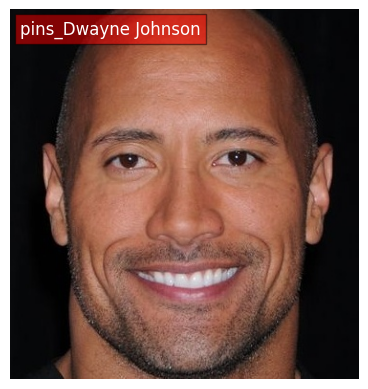

In [ ]:
from torchvision import transforms
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Görüntüyü yükle ve işle
image_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Dwayne Johnson/Dwayne Johnson132_1583.jpg'  # Test görüntüsünün yolu
image = Image.open(image_path).convert('RGB')

# Görüntüyü modelin beklediği formata dönüştür
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception modeli için uygun boyut
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet için ortalama ve std
])

image_tensor = transform(image).unsqueeze(0)  # Batch boyutunu ekleyin
image_tensor = image_tensor.to(device)  # Görüntüyü doğru cihaza taşıyın

# Modelle tahmin yap
with torch.no_grad():
    outputs = model_loaded(image_tensor)
    _, preds = torch.max(outputs, 1)

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Tahmin edilen sınıf numarasını al
predicted_class_num = preds.item()

# Tahmin edilen sınıf numarasını sınıf adına çevir
predicted_class_name = idx_to_class[predicted_class_num]

plt.imshow(image)
plt.axis('off')  # Eksenleri kapat

# Tahmin edilen etiketi resmin üzerine yaz
# (10, 25) başlangıç konumunu belirtir. Bu değerleri ayarlayarak metnin pozisyonunu değiştirebilirsiniz.
plt.text(10, 25, predicted_class_name, color='white', fontsize=12, 
         bbox=dict(facecolor='red', alpha=0.5))

# Görseli göster
plt.show()